Nielsen data
===

In [1]:
import pandas as pd
import numpy as np

## Loading the data

In [2]:
panelist = pd.read_table("../../Nielsen/panelists_2016.tsv").set_index('Household_Cd')[['Fips_State_Cd', 'Fips_State_Desc', 'Fips_County_Cd', 'Fips_County_Desc', 'Panelist_ZipCd']]
panelist['household_county_fips'] = np.vectorize(int)(panelist.Fips_State_Cd * 1e3 + panelist.Fips_County_Cd)
panelist['household_zip3'] = panelist.Panelist_ZipCd // 100
panelist = panelist[['Fips_State_Desc', 'Fips_County_Desc', 'household_county_fips', 'household_zip3']].rename(columns={'Fips_State_Desc': 'household_state', 'Fips_County_Desc': 'household_county'})

In [3]:
panelist.head()

,household_state,household_county,household_county_fips,household_zip3
Household_Cd,,,,
2058978,CA,ALAMEDA,6001,945
2059041,CA,SONOMA,6097,954
2053746,PA,LANCASTER,42071,175
2053784,PA,LANCASTER,42071,176
2055288,CA,ALAMEDA,6001,945


In [4]:
purchases = pd.read_csv("../../Nielsen/purchases_subset_2016.csv")
purchases['upc_price'] = purchases.total_price_paid / purchases.quantity
purchases = purchases[['trip_code_uc', 'upc', 'upc_price']]


In [5]:
purchases.head()

,trip_code_uc,upc,upc_price
0,1074839376,1111040601,1.49
1,1067492860,1111040601,1.13
2,1073807635,1111040601,1.21
3,1066280722,1111040601,1.82
4,1074711109,1111040601,1.48


In [6]:
trips = pd.read_table("../../Nielsen/trips_2016.tsv", parse_dates=['purchase_date']).set_index('trip_code_uc')[['purchase_date', 'retailer_code', 'store_code_uc', 'store_zip3', 'household_code']]
# colonnes à enlever : panel_year, total_spent, method_of_payment_cd

In [7]:
trips.head()

,purchase_date,retailer_code,store_code_uc,store_zip3,household_code
trip_code_uc,,,,,
1065667000,2016-10-23,2,4239361,190.0,2054802
1065667001,2016-12-20,9850,0,NaN,8648515
1065667002,2016-11-14,6920,3727506,730.0,30230428
1065667003,2016-08-10,6920,3001662,605.0,2071112
1065667004,2016-04-25,5851,0,NaN,2076738


In [8]:
# Proportion of unnumerotated stores
len(trips[trips.store_code_uc==0])/len(trips)

0.48677700294119425

In [9]:
explore = trips[trips.store_code_uc==0]

In [69]:
explore.groupby('retailer_code').count().describe()

,purchase_date,store_code_uc,store_zip3,household_code
count,814.000000,814.000000,814.0,814.000000
mean,6425.955774,6425.955774,0.0,6425.955774
std,22940.367216,22940.367216,0.0,22940.367216
min,1.000000,1.000000,0.0,1.000000
25%,32.000000,32.000000,0.0,32.000000
50%,322.500000,322.500000,0.0,322.500000
75%,2664.750000,2664.750000,0.0,2664.750000
max,246742.000000,246742.000000,0.0,246742.000000


In [72]:
s=0
for retailer in trips[trips.store_code_uc!=0].retailer_code.unique():
    if retailer in explore.retailer_code.unique():
        s+=1
print(s)

354


## Getting the store state

In [8]:
state_fips = pd.read_table('states_fips.txt', header=0, names=['state_fips', 'state', 'state_abbr', 'state_code']).set_index('state_fips')[['state_code']]
state_fips.head()

,state_code
state_fips,
1,AL
2,AK
4,AZ
5,AR
6,CA


In [9]:
trips.head()

,purchase_date,retailer_code,store_code_uc,store_zip3,household_code
trip_code_uc,,,,,
1065667000,2016-10-23,2,4239361,190.0,2054802
1065667001,2016-12-20,9850,0,NaN,8648515
1065667002,2016-11-14,6920,3727506,730.0,30230428
1065667003,2016-08-10,6920,3001662,605.0,2071112
1065667004,2016-04-25,5851,0,NaN,2076738


In [10]:
zip_to_state = pd.read_table('zip_prefixes.txt', header=0, names=['zip3','state', 'distib_center', 'towns'])[['zip3', 'state']]

non_null = trips[trips.store_code_uc != 0]
non_null = non_null.merge(zip_to_state, left_on='store_zip3', right_on='zip3')[['purchase_date', 'retailer_code', 'store_code_uc', 'household_code', 'state', 'store_zip3']]
non_null

,purchase_date,retailer_code,store_code_uc,household_code,state,store_zip3
0,2016-10-23,2,4239361,2054802,PA,190.0
1,2016-03-20,24,254521,30367513,PA,190.0
2,2016-02-24,120,1021442,30730891,PA,190.0
3,2016-06-14,120,4301315,30201210,PA,190.0
4,2016-11-16,2,977112,8646012,PA,190.0
...,...,...,...,...,...,...
5514902,2016-12-24,45,1996462,8286051,VT,53.0
5514903,2016-01-09,4901,3520966,8306752,VT,53.0
5514904,2016-01-19,34,1997671,8620167,VT,53.0
5514905,2016-12-28,45,1996462,8286051,VT,53.0


## Getting the store county - mode

In [11]:
## Getting the store state
df_ = non_null.merge(panelist, left_on='household_code', right_on='Household_Cd')[['retailer_code', 'store_code_uc', 'state', 'store_zip3', 'household_state', 'household_county_fips', 'household_county', 'household_zip3']]
df_

,retailer_code,store_code_uc,state,store_zip3,household_state,household_county_fips,household_county,household_zip3
0,2,4239361,PA,190.0,PA,42045,DELAWARE,190
1,6905,2890557,PA,190.0,PA,42045,DELAWARE,190
2,6905,2890557,PA,190.0,PA,42045,DELAWARE,190
3,2,4239361,PA,190.0,PA,42045,DELAWARE,190
4,6920,7620551,PA,190.0,PA,42045,DELAWARE,190
...,...,...,...,...,...,...,...,...
5514902,6920,7847066,WY,823.0,WY,56007,CARBON,823
5514903,272,2723868,WY,823.0,WY,56007,CARBON,823
5514904,6920,7847066,WY,823.0,WY,56007,CARBON,823
5514905,6920,7847066,WY,823.0,WY,56007,CARBON,823


In [12]:
# The store county is assumed to be the one where the maximum of households comes form.

# Fisrt, we delete all the housolds that do not come from the store state.

a = len(df_)
df_ = df_[df_.household_state == df_.state] # TOUT RENOMMER
print(f"Taux de suppression : {1-len(df_)/a} (proportion de foyers qui ne vont pas dans un store de leur Etat")

Taux de suppression : 0.027529022701561434 (proportion de foyers qui ne vont pas dans un store de leur Etat


In [13]:
# Fisrt, we delete all the housolds that do not come from the store zip3 zone.

a = len(df_)
df__ = df_[df_.household_zip3 == df_.store_zip3] # TOUT RENOMMER
print(f"Taux de suppression : {1-len(df__)/a} (proportion de foyers qui ne vont pas dans un store de leur Etat")

Taux de suppression : 0.14616842874262526 (proportion de foyers qui ne vont pas dans un store de leur Etat


In [15]:
uscities = pd.read_csv('../data_display/uscities.csv')[['state_id', 'county_fips', 'zips']]
uscities['zips'] = uscities.zips.apply(str).apply(str.split)
uscities = uscities.explode('zips')
uscities = uscities[(uscities.zips !='unknown') & (uscities.zips!='nan')]
uscities['zip3'] = np.vectorize(int)(uscities.zips)//100
uscities = uscities[['state_id', 'county_fips', 'zip3']].drop_duplicates()
store_counties = uscities.groupby('zip3')['county_fips'].apply(list).reset_index(name='possible_store_counties')
store_counties.head()

,zip3,possible_store_counties
0,6,"[72005, 72013, 72125, 72097, 72153, 72054, 721..."
1,7,"[72113, 72053, 72025, 72075, 72057, 72069, 720..."
2,9,"[72127, 72021, 72031, 72061, 72139, 72033, 721..."
3,10,"[25013, 25015, 25027]"
4,11,[25013]


In [18]:
df__.head()

,retailer_code,store_code_uc,state,store_zip3,household_county_fips,household_county,household_state,zip3,possible_store_counties
0,2,4239361,PA,190.0,42045,DELAWARE,PA,190,42017
0,2,4239361,PA,190.0,42045,DELAWARE,PA,190,42091
0,2,4239361,PA,190.0,42045,DELAWARE,PA,190,42029
1,6905,2890557,PA,190.0,42045,DELAWARE,PA,190,42017
1,6905,2890557,PA,190.0,42045,DELAWARE,PA,190,42091


In [19]:
# Then, we delete all the housolds that do not come from the country (based on the 3 first figures of the zip_code)
a = len(df_)
df__ = df_.merge(store_counties, left_on='store_zip3', right_on='zip3').explode('possible_store_counties')
df__ = df__[df__.household_county_fips != df__.possible_store_counties][['retailer_code', 'store_code_uc', 'state', 'store_zip3', 'household_county_fips', 'household_county', 'household_state', 'zip3']].drop_duplicates() # TOUT RENOMMER
print(f"Taux de suppression : {1-len(df__)/a} (proportion de foyers qui ne vont pas dans un store de leur county)")

Taux de suppression : 0.987655989917747 (proportion de foyers qui ne vont pas dans un store de leur Etat


In [14]:
from random import choice

def my_mode(self):
    return choice(list(pd.Series.mode(self)))

In [15]:
# Then, we select the mode :
store_counties = df__.groupby(['store_code_uc'])[['retailer_code', 'state', 'household_county_fips', 'household_county']].agg(my_mode)
store_counties.head()


,retailer_code,state,household_county_fips,household_county
store_code_uc,,,,
236,363,MN,27123,RAMSEY
540,4914,NC,37183,WAKE
557,3997,IL,17031,COOK
588,848,CA,6037,LOS ANGELES
920,290,FL,12099,PALM BEACH


In [16]:
def my_max(x):
    try:
        return max(x)
    except:
        return x
def my_sum(x):
    try:
        return sum(x)
    except:
        return x

In [17]:
test = df__.groupby(['store_code_uc'])[['household_county_fips', 'household_county']].agg(pd.Series.value_counts)
test['max_obs'] = test.household_county.apply(my_max)
test['nb_obs'] = test.household_county.apply(my_sum)
test['max_freq'] = test.max_obs / test.nb_obs
test.head()

,household_county_fips,household_county,max_obs,nb_obs,max_freq
store_code_uc,,,,,
236,2,2,2,2,1.000000
540,8,8,8,8,1.000000
557,143,143,143,143,1.000000
588,2,2,2,2,1.000000
920,"[60, 5]","[60, 5]",60,65,0.923077


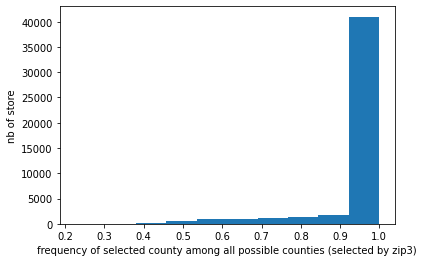

In [20]:
import matplotlib.pyplot as plt
plt.xlabel('frequency of selected county among all possible counties (selected by zip3)')
plt.ylabel('nb of store')
plt.hist(test.max_freq.to_list());

In [19]:
print(test.max_freq.quantile(0.1))
print(test.max_freq.quantile(0.2))
print(test.max_freq.quantile(0.3))

0.8333333333333334
1.0
1.0


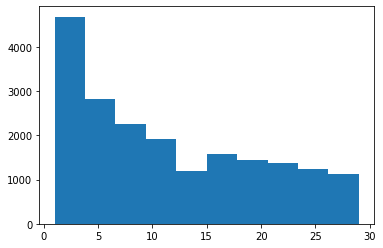

In [25]:
plt.hist(test.nb_obs[test.nb_obs<30]);

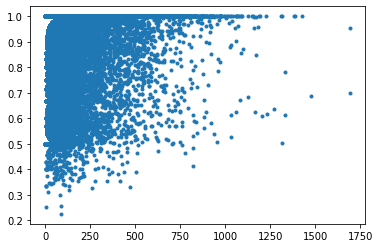

In [22]:
plt.scatter(test.nb_obs, test.max_freq, marker='.');

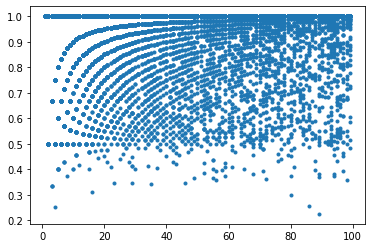

In [21]:
plt.scatter(test.nb_obs[test.nb_obs<100], test.max_freq[test.nb_obs<100], marker='.');

In [27]:
## Verification found county in state (pas nécessaire si on vire les counties "étrangers")
if False :
    zip_to_state = pd.read_table('zip_prefixes.txt', header=0, names=['zip3','state', 'distib_center', 'towns'])[['zip3', 'state']]


    state_fips = pd.read_table('states_fips.txt', header=0, names=['state_fips', 'state', 'state_abbr', 'state_code']).set_index('state_fips')[['state_code']]

    def fips_to_state(fips):

        return state_fips.loc[fips//1000]['state_code']

    store_counties['supposed_state'] = store_counties.County_fips.apply(fips_to_state)
    print(f"Taux d'erreur de prévision de l'Etat : {len(store_counties[store_counties.state != store_counties.supposed_state])/len(store_counties)}")

Taux d'erreur de prévision de l'Etat : 0.0


In [27]:
## Merging :

df__ = purchases.merge(trips, on='trip_code_uc')[['trip_code_uc','purchase_date', 'retailer_code', 'household_code', 'upc', 'upc_price']]
df__['purchase_month'] = df__.purchase_date.dt.month

In [28]:
df__.head()

,trip_code_uc,purchase_date,retailer_code,household_code,upc,upc_price,purchase_month
0,1074839376,2016-12-22,130,8006004,1111040601,1.49,12
1,1074839376,2016-12-22,130,8006004,1111091620,1.41,12
2,1067492860,2016-01-16,130,8151352,1111040601,1.13,1
3,1067492860,2016-01-16,130,8151352,1111086901,4.57,1
4,1067492860,2016-01-16,130,8151352,1111078495,1.50,1


In [29]:
prices = pd.DataFrame(df__.groupby(['retailer_code','purchase_month', 'upc']).mean()['upc_price']).reset_index().merge(store_counties, on='retailer_code')
prices.head()

KeyboardInterrupt: 